# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from statsmodels.discrete.discrete_model import MNLogit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

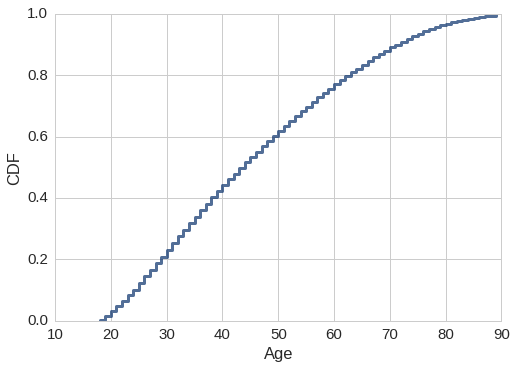

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

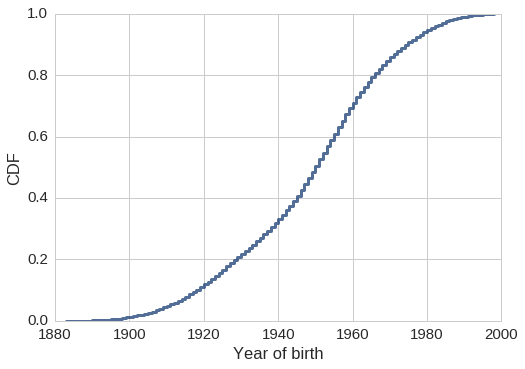

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5

In [19]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       2
1886.5      37
1891.5     140
1896.5     365
1901.5     726
1906.5    1113
1911.5    1648
1916.5    2281
1921.5    2798
1926.5    3131
1931.5    3074
1936.5    3632
1941.5    4343
1946.5    5616
1951.5    6349
1956.5    6465
1961.5    5556
1966.5    4413
1971.5    3483
1976.5    2631
1981.5    2044
1986.5    1280
1991.5     658
1996.5     210
Name: relig, dtype: int64

In [20]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [21]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

In [22]:
utils.values(gss, 'year')

1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: year, dtype: int64

In [23]:
sum(gss.relig.isnull())

0

In [24]:

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # lumping "Orthodox-Christian" and "Christian" with Protestant
    df['prot'] = (df.relig.isin([1,10,11]))
    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    varnames = ['prot', 'cath', 'none', 'other']
    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(gss)

In [25]:
utils.values(gss, 'relig4')

1.0    36728
2.0    15136
3.0     2900
4.0     7231
Name: relig4, dtype: int64

In [26]:
sum(gss.god.isnull())

39773

In [27]:
def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ['strongbelief', 'belief', 'nobelief', 'belief3']
    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(gss)

In [28]:
utils.values(gss, 'belief3')

1.0     1778
2.0     6819
3.0    13625
Name: belief3, dtype: int64

In [29]:
sum(gss.conclerg.isnull())

21354

In [30]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    varnames = ['confident', 'someconf', 'noconf']
    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(gss)

In [31]:
utils.values(gss, 'conclerg')

1.0    11308
2.0    20740
3.0     8593
Name: conclerg, dtype: int64

In [32]:
sum(gss.bible.isnull())

29138

In [33]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    varnames = ['word', 'inspired', 'legends']
    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(gss)

In [34]:
utils.values(gss, 'bible')

1.0    11123
2.0    15843
3.0     5891
Name: bible, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [35]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,nobelief,belief,strongbelief,belief3,confident,someconf,noconf,word,inspired,legends
0,1972,NaN,NaN,1918.0,54.0,1.7786,0,3.0,12,915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,NaN,NaN,1929.0,43.0,0.8893,0,2.0,12,542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972,NaN,NaN,1905.0,67.0,1.3339,0,1.0,99,1601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1972,NaN,NaN,1945.0,27.0,0.8893,0,1.0,5,561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1972,NaN,NaN,1909.0,63.0,0.4446,0,1.0,13,556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [37]:
center_factors(sample)

In [38]:
formula = 'prot ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.663865
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.02219
Time:                        16:44:13   Log-Likelihood:                -41156.
converged:                       True   LL-Null:                       -42090.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0825      0.017      4.992      0.000       0.050       0.115
c             -0.0211      0.001    -23.755      0.000      -0.023      -0.019
c2            -0.0001   1.85e-05     -6.441      0.000      -0.000    -8.3e-05
a              0.0008      0.001      0.994      0.320      -0.001       0.002
a2          8.149e-06   3.16e-05      0.258      0.796   -5.38e-05    7.01e-05
==============================================================================
"""

In [39]:
formula = 'cath ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.565210
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.001818
Time:                        16:44:13   Log-Likelihood:                -35040.
converged:                       True   LL-Null:                       -35104.
                                        LLR p-value:                 1.256e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1258      0.019    -59.915      0.000      -1.163      -1.089
c             -0.0040      0.001     -4.002      0.000      -0.006      -0.002
c2         -6.209e-05   2.06e-05     -3.021      0.003      -0.000   -2.18e-05
a             -0.0071      0.001     -8.106      0.000      -0.009      -0.005
a2          1.667e-05   3.52e-05      0.473      0.636   -5.24e-05    8.57e-05
==============================================================================
"""

In [40]:
formula = 'none ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.334877
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.06368
Time:                        16:44:14   Log-Likelihood:                -20761.
converged:                       True   LL-Null:                       -22173.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5320      0.024    -64.151      0.000      -1.579      -1.485
c              0.0407      0.001     33.570      0.000       0.038       0.043
c2         -4.564e-05   3.35e-05     -1.364      0.173      -0.000    1.99e-05
a              0.0117      0.001      8.809      0.000       0.009       0.014
a2             0.0001   5.52e-05      2.442      0.015    2.66e-05       0.000
==============================================================================
"""

In [41]:
formula = 'other ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.188608
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.003682
Time:                        16:44:14   Log-Likelihood:                -11693.
converged:                       True   LL-Null:                       -11736.
                                        LLR p-value:                 7.608e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8191      0.037    -76.592      0.000      -2.891      -2.747
c              0.0132      0.002      6.819      0.000       0.009       0.017
c2          6.534e-05   4.19e-05      1.559      0.119   -1.68e-05       0.000
a              0.0046      0.002      2.490      0.013       0.001       0.008
a2         -7.559e-05   7.43e-05     -1.018      0.309      -0.000       7e-05
==============================================================================
"""

## Generational replacement

Choose colors

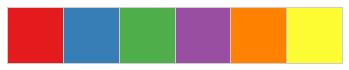

In [42]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [43]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [44]:
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['prot', 'cath', 'none', 'other']
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [45]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

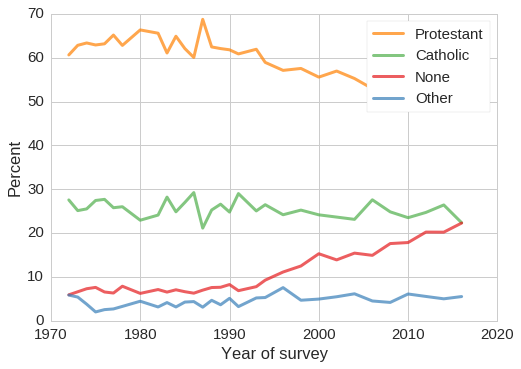

In [46]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [47]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1493
22.5    6189
27.5    6623
32.5    6507
37.5    6200
42.5    6167
47.5    5700
52.5    5296
57.5    4628
62.5    3878
67.5    3191
72.5    2579
77.5    1820
82.5    1051
87.5     673
Name: none, dtype: int64

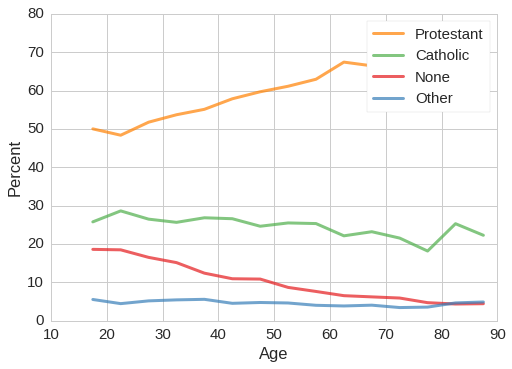

In [48]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [49]:
grouped_cohort = sample.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       4
1886.5      24
1891.5      96
1896.5     276
1901.5     623
1906.5     901
1911.5    1334
1916.5    2084
1921.5    2609
1926.5    3090
1931.5    3037
1936.5    3713
1941.5    4368
1946.5    5571
1951.5    6197
1956.5    6598
1961.5    5690
1966.5    4539
1971.5    3689
1976.5    2794
1981.5    2166
1986.5    1541
1991.5     745
1996.5     306
Name: relig, dtype: int64

In [50]:
since_1900 = sample.loc[sample.cohort >= 1900]
grouped_cohort = since_1900.groupby(['cohort5'])

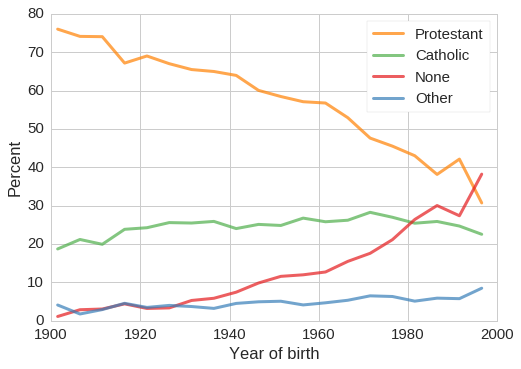

In [51]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [52]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [53]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,noconf,word,inspired,legends,ones,c,c2,a,a2,ac
0,1972,NaN,NaN,1918.0,54.0,1.7786,0,3.0,12,915,...,NaN,NaN,NaN,NaN,1.0,-48.0,2304.0,7.0,49.0,-336.0
1,1972,NaN,NaN,1929.0,43.0,0.8893,0,2.0,12,542,...,NaN,NaN,NaN,NaN,1.0,-37.0,1369.0,-4.0,16.0,148.0
2,1972,NaN,NaN,1905.0,67.0,1.3339,0,1.0,99,1601,...,NaN,NaN,NaN,NaN,1.0,-61.0,3721.0,20.0,400.0,-1220.0
3,1972,NaN,NaN,1945.0,27.0,0.8893,0,1.0,5,561,...,NaN,NaN,NaN,NaN,1.0,-21.0,441.0,-20.0,400.0,420.0
4,1972,NaN,NaN,1909.0,63.0,0.4446,0,1.0,13,556,...,NaN,NaN,NaN,NaN,1.0,-57.0,3249.0,16.0,256.0,-912.0


## Religious affiliation

Run logistic regression to fit models to each religious group.

In [54]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [55]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.663532
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.02268
Time:                        16:44:15   Log-Likelihood:                -41136.
converged:                       True   LL-Null:                       -42090.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0171      0.019      0.881      0.378      -0.021       0.055
c             -0.0334      0.002    -15.795      0.000      -0.038      -0.029
c2            -0.0004   5.32e-05     -8.272      0.000      -0.001      -0.000
a             -0.0126      0.002     -5.677      0.000      -0.017      -0.008
a2            -0.0004   6.67e-05     -5.555      0.000      -0.001      -0.000
ac            -0.0007      0.000     -6.436      0.000      -0.001      -0.000
==============================================================================
"""

In [56]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.565201
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.001833
Time:                        16:44:16   Log-Likelihood:                -35040.
converged:                       True   LL-Null:                       -35104.
                                        LLR p-value:                 4.459e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1134      0.022    -50.215      0.000      -1.157      -1.070
c             -0.0017      0.002     -0.711      0.477      -0.006       0.003
c2         -3.843e-06   5.93e-05     -0.065      0.948      -0.000       0.000
a             -0.0046      0.003     -1.841      0.066      -0.010       0.000
a2          8.568e-05   7.47e-05      1.146      0.252   -6.08e-05       0.000
ac             0.0001      0.000      1.046      0.295      -0.000       0.000
==============================================================================
"""

In [57]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.334406
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.06499
Time:                        16:44:16   Log-Likelihood:                -20732.
converged:                       True   LL-Null:                       -22173.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4368      0.027    -54.080      0.000      -1.489      -1.385
c              0.0623      0.003     20.336      0.000       0.056       0.068
c2             0.0006   8.46e-05      6.557      0.000       0.000       0.001
a              0.0349      0.003     10.642      0.000       0.028       0.041
a2             0.0008      0.000      7.940      0.000       0.001       0.001
ac             0.0013      0.000      7.721      0.000       0.001       0.002
==============================================================================
"""

In [58]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.188578
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.003845
Time:                        16:44:16   Log-Likelihood:                -11691.
converged:                       True   LL-Null:                       -11736.
                                        LLR p-value:                 5.965e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8616      0.043    -66.306      0.000      -2.946      -2.777
c              0.0047      0.005      0.991      0.322      -0.005       0.014
c2            -0.0002      0.000     -1.302      0.193      -0.000    8.11e-05
a             -0.0048      0.005     -0.925      0.355      -0.015       0.005
a2            -0.0004      0.000     -2.190      0.029      -0.001   -3.68e-05
ac            -0.0005      0.000     -1.948      0.051      -0.001    3.14e-06
==============================================================================
"""

In [59]:
formula = 'relig4 ~ a + c'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.026999
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61986
Method:                           MLE   Df Model:                            6
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.02625
Time:                        16:44:16   Log-Likelihood:                -63669.
converged:                       True   LL-Null:                       -65385.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7403      0.017    -42.562      0.000      -0.774      -0.706
a             -0.0053      0.001     -5.906      0.000      -0.007      -0.004
c              0.0060      0.001      7.949      0.000       0.004       0.007
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2101      0.033    -67.466      0.000      -2.274      -2.146
a              0.0049      0.002      2.709      0.007       0.001       0.009
c              0.0183      0.002     12.060      0.000       0.015       0.021
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0457      0.021    -48.957      0.000      -1.088      -1.004
a              0.0096      0.001      7.283      0.000       0.007       0.012
c              0.0443      0.001     40.474      0.000       0.042       0.046
==============================================================================
"""

## Multinomial models

In [60]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X).fit(disp=False, full_output=False)

In [61]:
def predict_multi_model(age, model, year, factors, index):
    """Make a prediction based on a fitted model.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps variable name to percentage
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    X = df[factors].values
    pred = model.predict(X)
    means = pred.mean(axis=0)
    
    freqs = np.random.multinomial(n, means) / n
    
    #xs = np.arange(1, model.model.J+1)
    #func = lambda row: np.random.choice(xs, p=row)
    #choices = np.apply_along_axis(func, 1, pred)
    #_, counts = np.unique(choices, return_counts=True)
    #freqs = counts / n

    return pd.Series(freqs, index=index) * 100

In [62]:
train_year = 2016
train = sample[sample.year <= train_year]

In [63]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

In [64]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

In [65]:
predict_multi_model(age, model, 1976, factors, index)

prot     66.713632
cath     24.304333
other     3.663262
none      5.318774
dtype: float64

In [66]:
ps = np.array([ 0.66491488,  0.25305637,  0.03519866,  0.04683008])
xs = np.arange(1, len(ps)+1)

np.random.choice(xs, p=ps)
xs

array([1, 2, 3, 4])

In [67]:
predict_multi_model(age, model, 2016, factors, index)

prot     48.573441
cath     23.599859
other     5.776682
none     22.050018
dtype: float64

In [68]:
predict_multi_model(age, model, 2026, factors, index)

prot     45.262416
cath     22.367031
other     6.023248
none     26.347305
dtype: float64

In [69]:
predict_multi_model(age, model, 2036, factors, index)

prot     38.182459
cath     18.985558
other     6.234590
none     36.597393
dtype: float64

In [70]:
def plot_predictions(series_seq, colors):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

In [71]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    train = df[df.year <= train_year]
    age = df.loc[df.year==train_year, 'age']
    
    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

def plot_multi_pred(df, pred, varnames, colors):
    series_seq = [pred[var] for var in varnames]
    plot_predictions(series_seq, colors)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

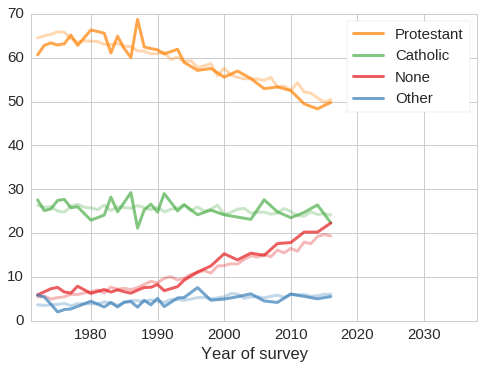

In [72]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
thinkplot.config(xlim=[1971, 2038])

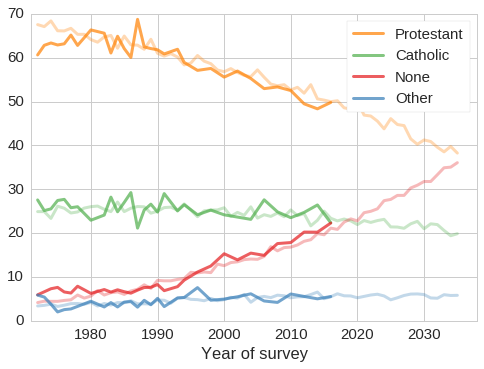

In [73]:
train_year = 2016
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

thinkplot.config(xlim=[1971, 2038])

## Belief in God

I don''t believe in God.....................1 

I don''t know whether there is a God and I don''t believe there is any way to find out..................................2

I don''t believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [74]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
belief_colors = [BLUE, PURPLE, RED]

In [75]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    varnames = ['strongbelief', 'belief', 'nobelief']
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

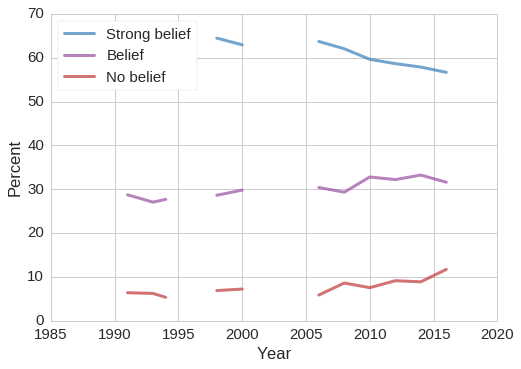

In [76]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

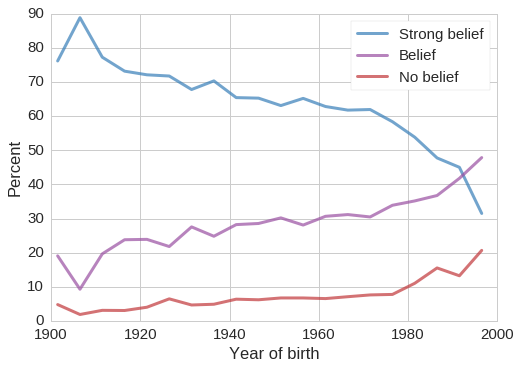

In [77]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [78]:
make_model(sample, 'strongbelief').summary()

Optimization terminated successfully.
         Current function value: 0.655018
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           strongbelief   No. Observations:                22186
Model:                          Logit   Df Residuals:                    22180
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.01573
Time:                        16:44:21   Log-Likelihood:                -14532.
converged:                       True   LL-Null:                       -14764.
                                        LLR p-value:                 3.595e-98
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4252      0.023     18.342      0.000       0.380       0.471
c             -0.0341      0.005     -7.243      0.000      -0.043      -0.025
c2            -0.0009      0.000     -4.053      0.000      -0.001      -0.000
a             -0.0168      0.005     -3.515      0.000      -0.026      -0.007
a2            -0.0009      0.000     -3.961      0.000      -0.001      -0.000
ac            -0.0016      0.000     -3.574      0.000      -0.002      -0.001
==============================================================================
"""

In [79]:
make_model(sample, 'belief').summary()

Optimization terminated successfully.
         Current function value: 0.611420
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 belief   No. Observations:                22186
Model:                          Logit   Df Residuals:                    22180
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.006981
Time:                        16:44:21   Log-Likelihood:                -13565.
converged:                       True   LL-Null:                       -13660.
                                        LLR p-value:                 2.725e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7919      0.024    -32.420      0.000      -0.840      -0.744
c              0.0180      0.005      3.640      0.000       0.008       0.028
c2             0.0005      0.000      2.024      0.043    1.44e-05       0.001
a              0.0062      0.005      1.235      0.217      -0.004       0.016
a2             0.0005      0.000      2.087      0.037    3.07e-05       0.001
ac             0.0009      0.000      1.897      0.058   -2.85e-05       0.002
==============================================================================
"""

In [80]:
make_model(sample, 'nobelief').summary()

Optimization terminated successfully.
         Current function value: 0.266051
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               nobelief   No. Observations:                22186
Model:                          Logit   Df Residuals:                    22180
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.02072
Time:                        16:44:21   Log-Likelihood:                -5902.6
converged:                       True   LL-Null:                       -6027.5
                                        LLR p-value:                 6.174e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4318      0.041    -58.630      0.000      -2.513      -2.350
c              0.0536      0.008      6.412      0.000       0.037       0.070
c2             0.0013      0.000      3.177      0.001       0.000       0.002
a              0.0353      0.009      4.122      0.000       0.019       0.052
a2             0.0015      0.000      3.434      0.001       0.001       0.002
ac             0.0023      0.001      2.907      0.004       0.001       0.004
==============================================================================
"""

In [81]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.846924
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22186
Model:                        MNLogit   Df Residuals:                    22180
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.01273
Time:                        16:44:21   Log-Likelihood:                -18790.
converged:                       True   LL-Null:                       -19032.
                                        LLR p-value:                1.333e-103
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2607      0.035     36.322      0.000       1.193       1.329
c             -0.0218      0.003     -6.897      0.000      -0.028      -0.016
a             -0.0136      0.003     -3.938      0.000      -0.020      -0.007
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8824      0.033     57.119      0.000       1.818       1.947
c             -0.0341      0.003    -11.307      0.000      -0.040      -0.028
a             -0.0126      0.003     -3.809      0.000      -0.019      -0.006
==============================================================================
"""

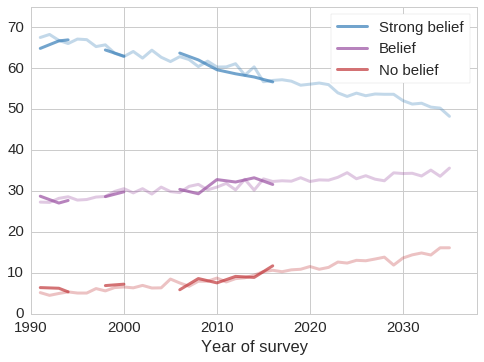

In [82]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

In [83]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

,strongbelief,belief,nobelief
1996,67.347658,27.650581,5.001761
2016,58.224727,31.983093,9.792180
2036,49.418809,35.012328,15.568862


## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [84]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    varnames = ['confident', 'someconf', 'noconf']
    colors = [BLUE, PURPLE, RED]
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

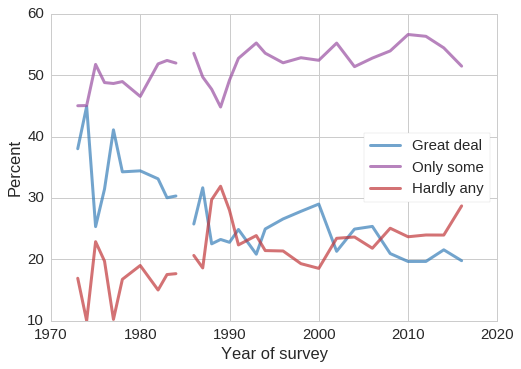

In [85]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

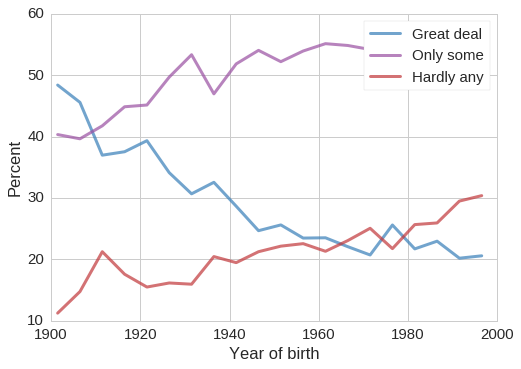

In [86]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [87]:
make_model(sample, 'confident').summary()

Optimization terminated successfully.
         Current function value: 0.579355
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              confident   No. Observations:                40571
Model:                          Logit   Df Residuals:                    40565
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                 0.02043
Time:                        16:44:22   Log-Likelihood:                -23505.
converged:                       True   LL-Null:                       -23995.
                                        LLR p-value:                1.094e-209
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4567      0.029    -49.745      0.000      -1.514      -1.399
c             -0.0088      0.003     -2.948      0.003      -0.015      -0.003
c2             0.0003   7.34e-05      4.142      0.000       0.000       0.000
a             -0.0033      0.003     -1.033      0.302      -0.009       0.003
a2             0.0006      9e-05      6.873      0.000       0.000       0.001
ac             0.0004      0.000      2.971      0.003       0.000       0.001
==============================================================================
"""

In [88]:
make_model(sample, 'someconf').summary()

Optimization terminated successfully.
         Current function value: 0.689186
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               someconf   No. Observations:                40571
Model:                          Logit   Df Residuals:                    40565
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.005188
Time:                        16:44:23   Log-Likelihood:                -27961.
converged:                       True   LL-Null:                       -28107.
                                        LLR p-value:                 6.262e-61
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2643      0.024     10.889      0.000       0.217       0.312
c              0.0003      0.003      0.122      0.903      -0.005       0.005
c2            -0.0002   6.46e-05     -2.778      0.005      -0.000   -5.29e-05
a              0.0001      0.003      0.041      0.967      -0.005       0.005
a2            -0.0004   8.07e-05     -4.400      0.000      -0.001      -0.000
ac            -0.0002      0.000     -1.204      0.229      -0.000       0.000
==============================================================================
"""

In [89]:
make_model(sample, 'noconf').summary()

Optimization terminated successfully.
         Current function value: 0.507920
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noconf   No. Observations:                40571
Model:                          Logit   Df Residuals:                    40565
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.006743
Time:                        16:44:23   Log-Likelihood:                -20607.
converged:                       True   LL-Null:                       -20747.
                                        LLR p-value:                 2.214e-58
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0907      0.028    -38.430      0.000      -1.146      -1.035
c              0.0051      0.003      1.671      0.095      -0.001       0.011
c2            -0.0002   7.96e-05     -3.046      0.002      -0.000   -8.65e-05
a              0.0005      0.003      0.166      0.868      -0.006       0.007
a2            -0.0003   9.98e-05     -2.762      0.006      -0.000   -8.01e-05
ac            -0.0004      0.000     -2.727      0.006      -0.001      -0.000
==============================================================================
"""

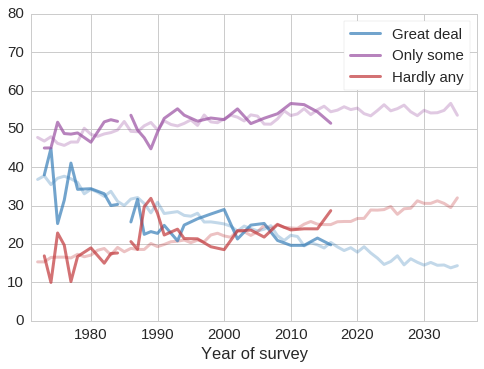

In [90]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 80])

In [91]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

,confident,someconf,noconf
1976,34.131737,49.418809,16.449454
2016,20.183163,53.927439,25.889398
2036,13.349771,55.653399,30.996830


## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [92]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    varnames = ['word', 'inspired', 'legends']
    colors = [BLUE, PURPLE, RED]
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

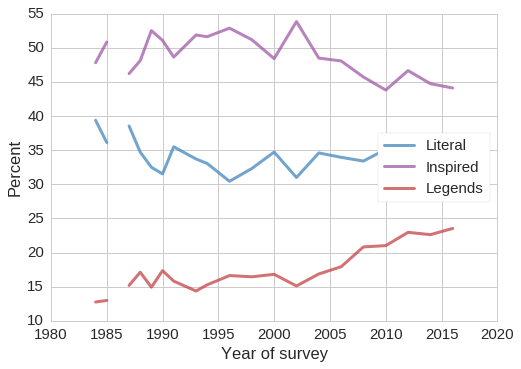

In [93]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

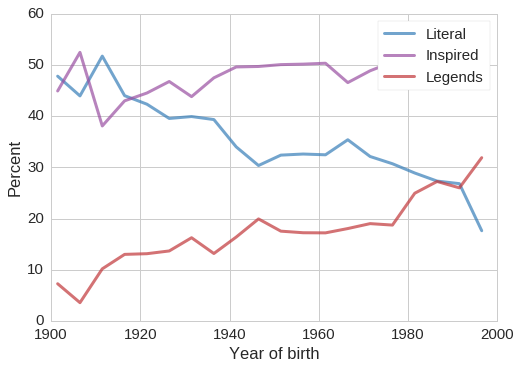

In [94]:
plot_bible(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [95]:
make_model(sample, 'word').summary()

Optimization terminated successfully.
         Current function value: 0.634056
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   word   No. Observations:                32720
Model:                          Logit   Df Residuals:                    32714
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.005454
Time:                        16:44:25   Log-Likelihood:                -20746.
converged:                       True   LL-Null:                       -20860.
                                        LLR p-value:                 3.598e-47
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7484      0.023    -32.860      0.000      -0.793      -0.704
c              0.0010      0.004      0.287      0.774      -0.006       0.008
c2             0.0003      0.000      1.875      0.061   -1.19e-05       0.001
a              0.0105      0.004      2.829      0.005       0.003       0.018
a2             0.0003      0.000      2.214      0.027    3.96e-05       0.001
ac             0.0005      0.000      1.849      0.064   -3.16e-05       0.001
==============================================================================
"""

In [96]:
make_model(sample, 'inspired').summary()

Optimization terminated successfully.
         Current function value: 0.690629
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inspired   No. Observations:                32720
Model:                          Logit   Df Residuals:                    32714
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.002847
Time:                        16:44:25   Log-Likelihood:                -22597.
converged:                       True   LL-Null:                       -22662.
                                        LLR p-value:                 3.829e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1684      0.022     -7.828      0.000      -0.211      -0.126
c             -0.0243      0.003     -7.113      0.000      -0.031      -0.018
c2            -0.0007      0.000     -5.209      0.000      -0.001      -0.000
a             -0.0263      0.004     -7.473      0.000      -0.033      -0.019
a2            -0.0007      0.000     -4.422      0.000      -0.001      -0.000
ac            -0.0012      0.000     -4.613      0.000      -0.002      -0.001
==============================================================================
"""

In [97]:
make_model(sample, 'legends').summary()

Optimization terminated successfully.
         Current function value: 0.469502
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                legends   No. Observations:                32720
Model:                          Logit   Df Residuals:                    32714
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2017   Pseudo R-squ.:                0.009484
Time:                        16:44:25   Log-Likelihood:                -15362.
converged:                       True   LL-Null:                       -15509.
                                        LLR p-value:                 1.793e-61
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2646      0.026    -47.917      0.000      -1.316      -1.213
c              0.0358      0.004      8.295      0.000       0.027       0.044
c2             0.0006      0.000      3.661      0.000       0.000       0.001
a              0.0263      0.004      5.895      0.000       0.018       0.035
a2             0.0005      0.000      2.719      0.007       0.000       0.001
ac             0.0012      0.000      3.290      0.001       0.000       0.002
==============================================================================
"""

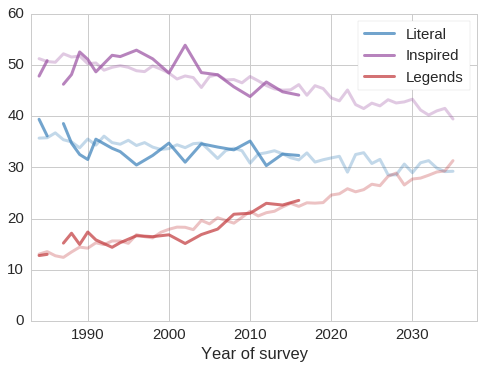

In [98]:
var = 'bible'
varnames = ['word', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])

In [99]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

,word,inspired,legends
1986,35.047552,51.356111,13.596337
2016,30.362804,46.812258,22.824938
2036,27.615358,40.612892,31.771751


## Resampling

In [100]:
import age_religion

gss = age_religion.read_gss()

In [101]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [102]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [103]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [104]:
def run_data(df, groupvar, varnames, iters=101):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [105]:
def run_model(df, var, varnames, train_year, years, index, iters=101):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    train_year: last year of data to use
    years: list of years to predict
    index: list of string variable names to extract
    iters: number of resamples
    """
    factors = ['ones', 'a', 'c']

    def run():
        sample = utils.ResampleByYear(df)
        return make_multi_pred(sample, var, varnames,
                               train_year, years, factors, index)

    dfs = [run() for _ in range(iters)]
    return dfs

## Affiliation

In [106]:
groupvar = 'year'
varnames = ['prot', 'cath', 'none', 'other']
dfs1 = run_data(gss, groupvar, varnames, iters=11)

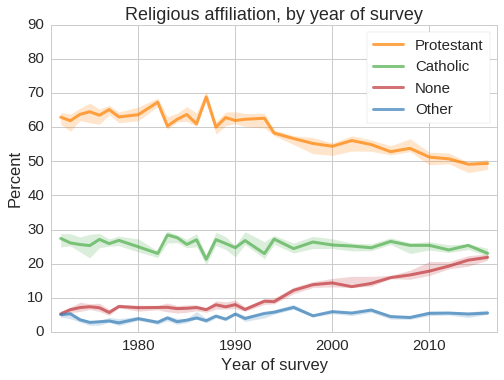

In [107]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[0, 90])

In [108]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=11)

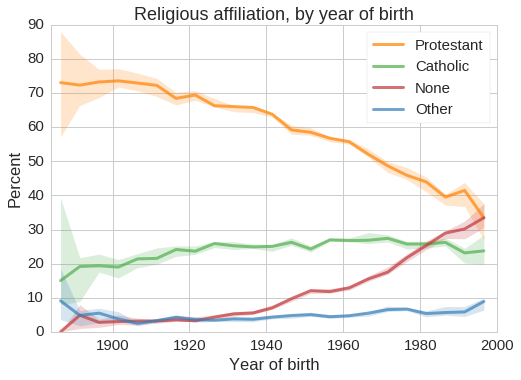

In [109]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs2, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], yim=[0, 90])

In [110]:
var = 'relig4'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

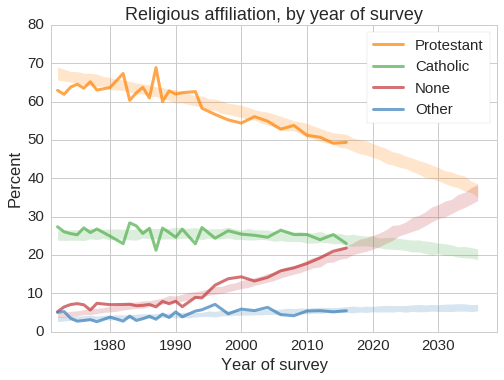

In [111]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [114]:
var = 'relig4'
train_year = 2006

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

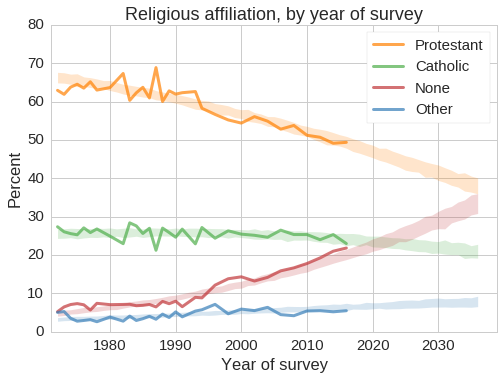

In [115]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [116]:
train_year = 1996

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

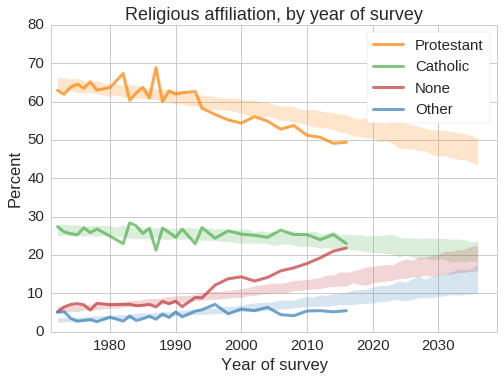

In [117]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [118]:
ps = np.array([0.5])
series_seq = [df['other'] for df in dfs3]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016]]

,0
1976,3.628038
1986,4.191617
1996,4.614301
2006,5.283551
2016,5.706235


## Beliefs

In [119]:
groupvar = 'year'
varnames = ['strongbelief', 'belief', 'nobelief']

In [120]:
dfs5 = run_data(gss, groupvar, varnames, iters=101)

In [146]:
colors = [BLUE, PURPLE, RED]
labels = ['Strong belief', 'Belief', 'No belief']

plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

KeyError: 'inspired'

In [122]:
groupvar = 'cohort5'
dfs6 = run_data(gss, groupvar, varnames, iters=101)

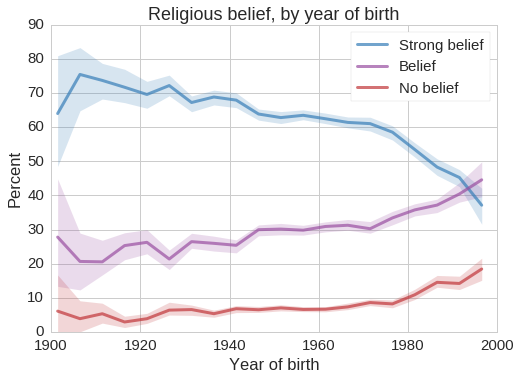

In [123]:
plot_percentiles(dfs6, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1900, 2000], ylim=[0, 90])

In [124]:
var = 'belief3'
train_year = 2016
years = np.arange(1988, 2037)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

In [125]:
dfs7 = run_model(gss, var, varnames, train_year, years, index, iters=101)

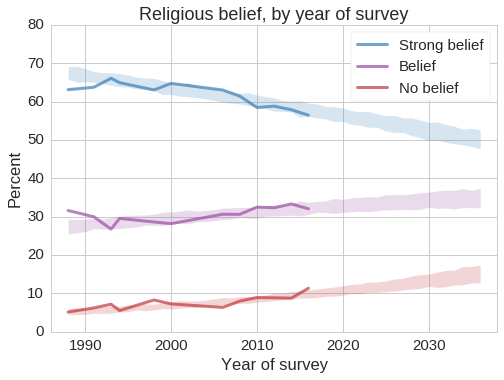

In [126]:
plot_percentiles(dfs7, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs5, varnames, colors, labels, fill=False)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1986, 2038], ylim=[0, 80])

In [127]:
var = 'nobelief'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs7]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,NaN
1996,6.445932
2006,7.854878
2016,9.792180
2026,12.116943
2036,14.547376


## Confidence

In [128]:
groupvar = 'year'
varnames = ['confident', 'someconf', 'noconf']

In [129]:
dfs8 = run_data(gss, groupvar, varnames, iters=101)

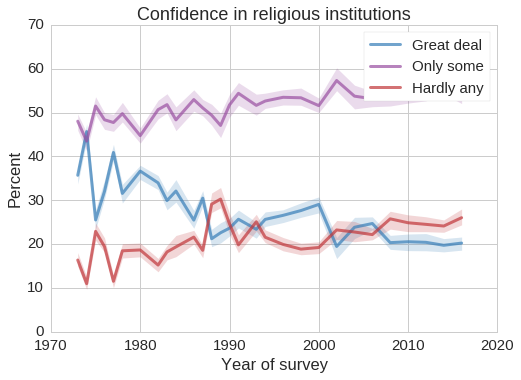

In [130]:
colors = [BLUE, PURPLE, RED]
labels = ['Great deal', 'Only some', 'Hardly any']

plot_percentiles(dfs8, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions', 
                 xlabel='Year of survey', ylabel='Percent')

In [131]:
groupvar = 'cohort5'
dfs9 = run_data(gss, groupvar, varnames, iters=101)

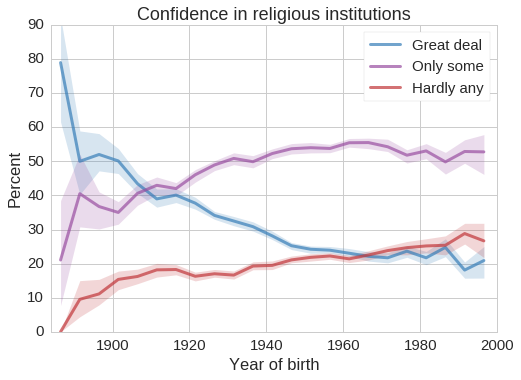

In [132]:
plot_percentiles(dfs9, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1884, 2000], ylim=[0, 90])

In [133]:
var = 'conclerg'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['confident', 'someconf', 'noconf']

In [134]:
dfs10 = run_model(gss, var, varnames, train_year, years, index, iters=101)

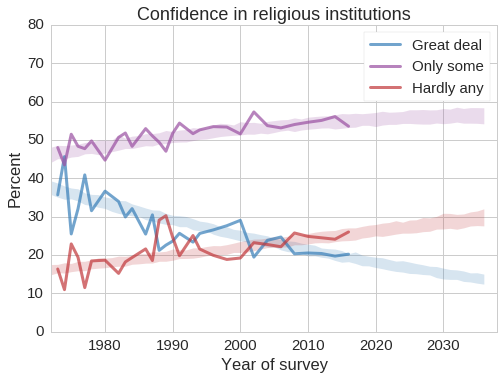

In [135]:
plot_percentiles(dfs10, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs8, varnames, colors, labels, fill=False)
thinkplot.config(title='Confidence in religious institutions', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2038], ylim=[0, 80])

In [136]:
var = 'noconf'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs10]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,16.942585
1986,19.126453
1996,21.169426
2006,23.318070
2016,25.537161
2026,27.615358
2036,29.799225


## Bible

In [137]:
groupvar = 'year'
varnames = ['inspired', 'literal', 'legends']

In [138]:
dfs11 = run_data(gss, groupvar, varnames, iters=101)

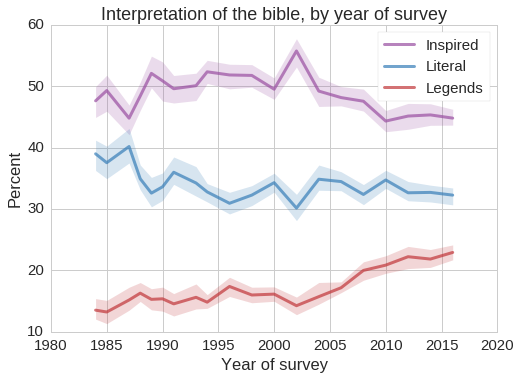

In [139]:
colors = [PURPLE, BLUE, RED]
labels = ['Inspired', 'Literal', 'Legends']

plot_percentiles(dfs11, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [140]:
groupvar = 'cohort5'
dfs12 = run_data(gss, groupvar, varnames, iters=101)

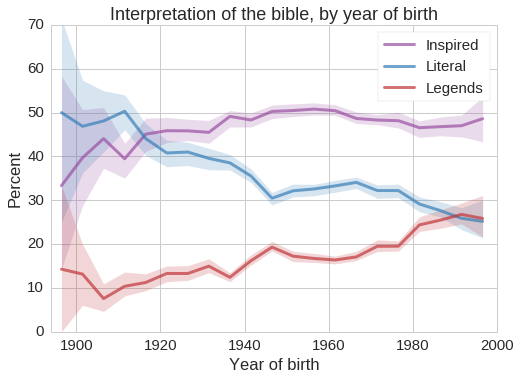

In [141]:
plot_percentiles(dfs12, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1894, 2000], ylim=[0, 70])

In [142]:
var = 'bible'
train_year = 2016
years = np.arange(1984, 2037)
factors = ['ones', 'a', 'c']
index = ['literal', 'inspired', 'legends']

In [143]:
dfs13 = run_model(gss, var, varnames, train_year, years, index, iters=101)

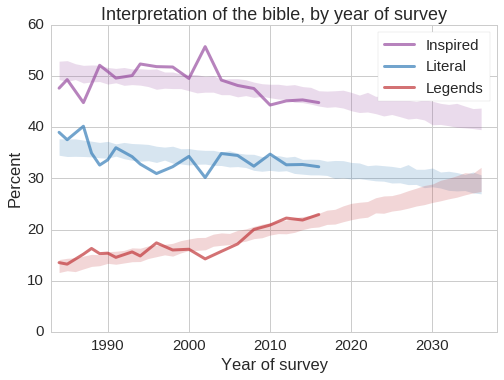

In [144]:
plot_percentiles(dfs13, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs11, varnames, colors, labels, fill=False)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1983, 2038], ylim=[0, 60])

In [145]:
var = 'legends'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs13]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,13.314547
1996,15.780204
2006,18.668545
2016,21.979570
2026,25.642832
2036,29.587883
